In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd

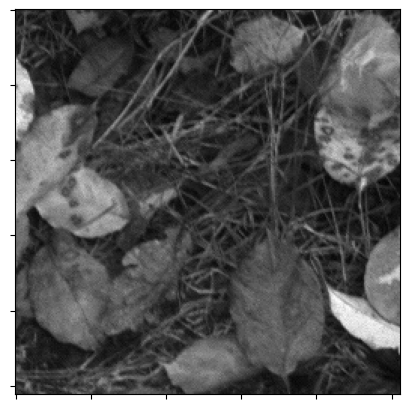

In [30]:
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 42069
rng = np.random.default_rng(seed)

images = fwd.load_images(n_images=10, crop_size=256, rng=rng)

images = [img / np.max(img) for img in images]

img = images[0]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img, cmap="gray")
ax.set(xticklabels=[], yticklabels=[]);

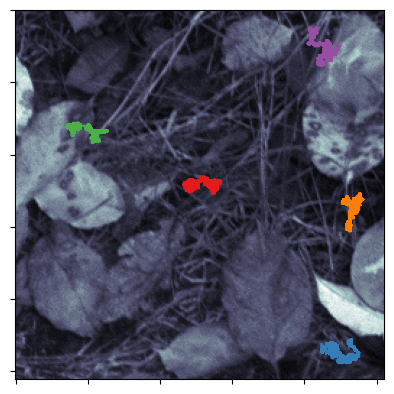

In [33]:
patch_h, patch_w = 12, 12
img_h, img_w = img.shape

sigma = .1
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="bone")
# plt.colorbar(im)
ax.set(xticklabels=[], yticklabels=[])

n_contexts = 5
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1, rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])

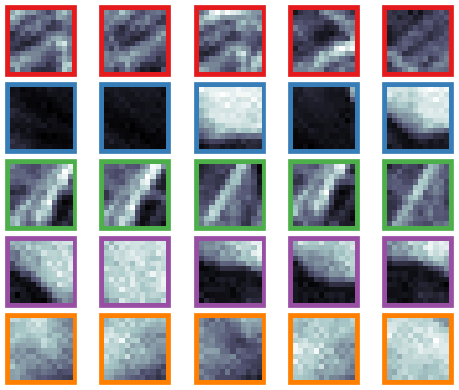

In [35]:
fwd.plot_context_samples(all_contexts, 5)

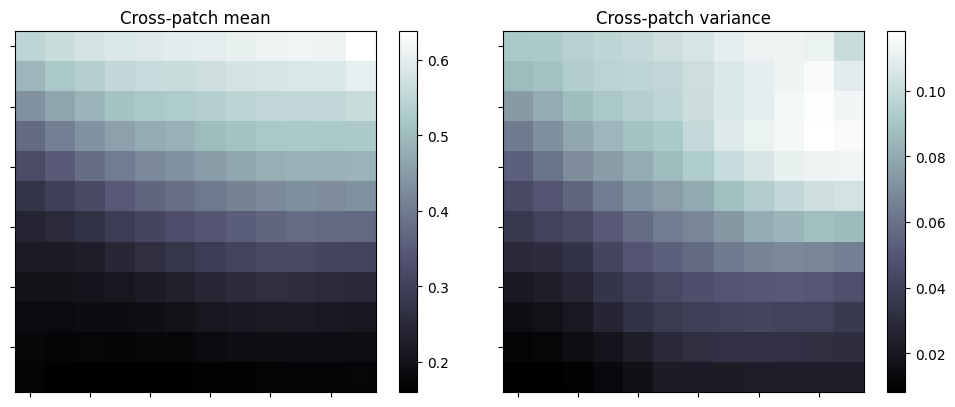

In [36]:
fwd.plot_patch_stats(all_contexts[1])

In [37]:
conv_h, conv_w = 4, 4
W = fw.get_conv_frame(patch_h, patch_w, conv_h, conv_w)

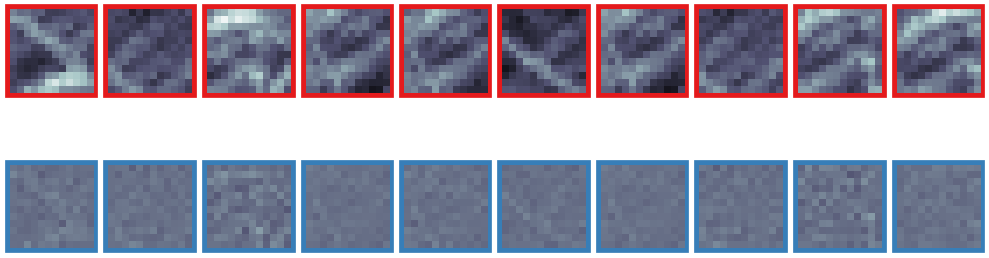

In [58]:
X = all_contexts[0]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 10

Cxx = np.cov(X0.T)
Cxx = Cxx + np.eye(Cxx.shape[0]) * 1e-4

ll, V = np.linalg.eigh(Cxx)
l12 = 1/np.sqrt(ll)
assert np.allclose(V @ np.diag(ll) @ V.T, Cxx)

W = V @ np.diag(l12) @ V.T

Xw = X0 @ W.T

Xw = Xw.reshape(n_steps, patch_h, patch_w)
X0 = X0.reshape(n_steps, patch_h, patch_w)

fwd.plot_context_samples(np.stack([X0, Xw], 0), 10)

In [70]:
import frame_whitening.simulation_new as sim
n_batch = 2048
g_last, g_all, errors, variances = sim.simulate([np.linalg.cholesky(Cxx)], W, -1, n_batch, 1E-3, None, False, True)

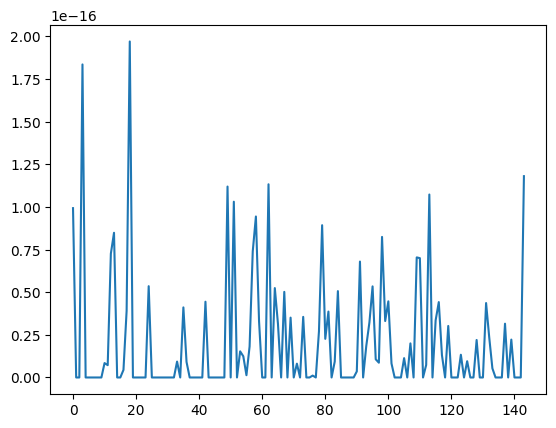

In [71]:
plt.plot(g_last[0])